<a href="https://colab.research.google.com/github/punkyBella/-/blob/master/Introduction_to_PytorchGeometric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size=6 weight='bold'>1st TC2 Summer School on Deep Learning on Graphs</font>

<font size=6 weight='bold'>Introduction to PyTorch Geometric</font>

<font size=5>
Speaker: Luca Cosmo </font><font size=4>(luca.cosmo@unive.it)</font><br>
<br><br>


Part of this notebook is adapted from the Pytorch Geometric library official tutorial. [link](https://pytorch-geometric.readthedocs.io/en/latest/get_started/colabs.html)

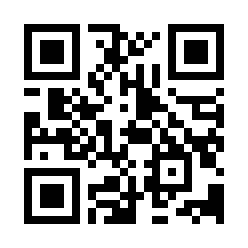

<font size=6> Link to this Notebook: https://bit.ly/45z4aEO </font>


# Introduction to Graph Neural Networks with Python

Recently, deep learning on graphs has emerged to one of the hottest research fields in the deep learning community.
Here, **Graph Neural Networks (GNNs)** aim to generalize classical deep learning concepts to irregular structured data (in contrast to images or texts) and to enable neural networks to reason about objects and their relations.

This is done by following a simple **neural message passing scheme**, where node features $\mathbf{x}_v^{(\ell)}$ of all nodes $v \in \mathcal{V}$ in a graph $\mathcal{G} = (\mathcal{V}, \mathcal{E})$ are iteratively updated by aggregating localized information from their neighbors $\mathcal{N}(v)$:

$$
\mathbf{x}_v^{(\ell + 1)} = f^{(\ell + 1)}_{\theta} \left( \mathbf{x}_v^{(\ell)}, \left\{ \mathbf{x}_w^{(\ell)} : w \in \mathcal{N}(v) \right\} \right)
$$

This tutorial will introduce you to some fundamental concepts regarding deep learning on graphs via Graph Neural Networks based on the **[PyTorch Geometric (PyG) library](https://github.com/rusty1s/pytorch_geometric)**.
PyTorch Geometric is an extension library to the popular deep learning framework [PyTorch](https://pytorch.org/), and consists of various methods and utilities to ease the implementation of Graph Neural Networks.

In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.0.1+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 23.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph(G, color, node_size=3):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_size=node_size, width=1, node_color=color, cmap="Set2")
    plt.show()

We will start by loading a common dataset for Node Classification, the Cora dataset.

It represents a **citation network** where nodes represent documents.
Each node is described by a 1433-dimensional bag-of-words feature vector.
Two documents are connected if there exists a citation link between them.
The task is to infer the category of each document (7 in total).

PyTorch Geometric provides an easy access to this and other standard datasets via the [`torch_geometric.datasets`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets) subpackage:

In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')


Processing...
Done!



Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7


In [ ]:
data = dataset[0]
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

Each graph in PyTorch Geometric is represented by a single [`Data`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data) object, which holds all the information to describe its graph representation.
We can print the data object anytime via `print(data)` to receive a short summary about its attributes and their shapes:
```
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
```
We can see that this `data` object holds 4 attributes:
1. The `edge_index` property holds the information about the **graph connectivity**, *i.e.*, a tuple of source and destination node indices for each edge.
2. the `x` property holds the **node features** as d-dimensional vectors
3. the `y` property holds the **node labels**. In node classification each node is assigned to exactly one class (this sis not the case for graph classification).

Additionaly, in node classification there also exists some additional attribute called `train/valid/test_mask`, which describes for which nodes we already know their community assigments during training, and which one should be predicted to asses the quality of the model.

<br>

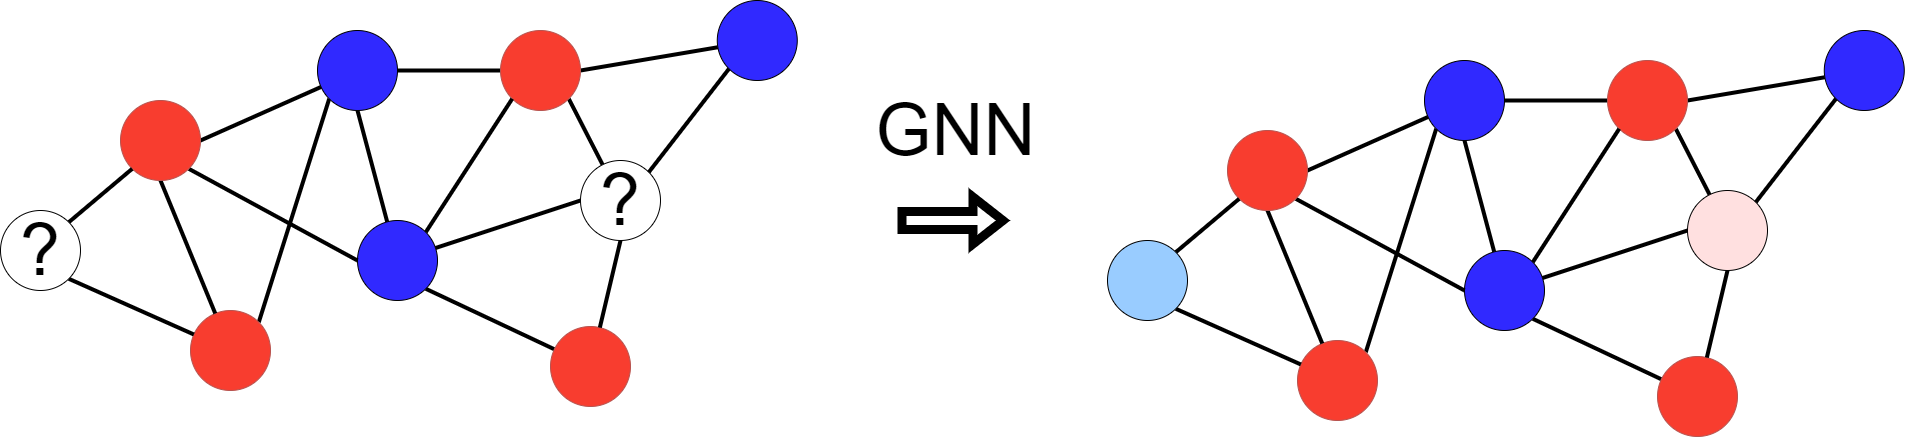

In [ ]:
data.train_mask

NameError: ignored

In [ ]:
data.edge_index

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])

By printing `edge_index`, we can understand how PyG represents graph connectivity internally. It does not hold the full Adjacency matrix, but rather it represent it as a sparse matrix using the **COO format (coordinate format)**.
That is, for each edge, `edge_index` holds a tuple of two node indices, where the first value describes the node index of the source node and the second value describes the node index of the destination node of an edge.

We can further visualize the graph by converting it to the `networkx` library format, which implements, in addition to graph manipulation functionalities, powerful tools for visualization:

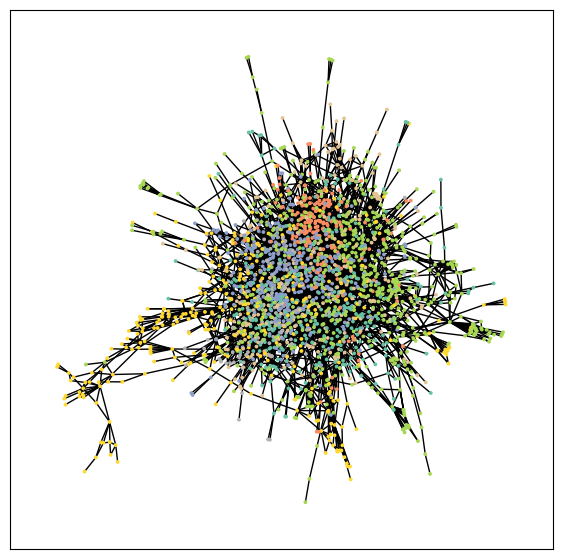

In [ ]:
import numpy as np
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
cc0 = next(iter(nx.connected_components(G)))
G = G.subgraph(cc0)
visualize_graph(G, color=data.y[list(cc0)])
# nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), node_size=20, width=1, with_labels=False,cmap="Set2")


## torch_geometric.nn
Similarly to the torch.nn module, **torch_geometric.nn** holds some pre-defined convolutional layers for graphs.
Have a look [here](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#convolutional-layers) for a comprehensive list.

We will start with on of the most simple GNN operators, the **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)), which is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{\sqrt{d_v d_w}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $d_*$ refers to the node degree.

PyG implements this layer via [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv).

In [ ]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(num_features, 64)
        self.act1 = torch.nn.Tanh()
        self.conv2 = GCNConv(64, 64)
        self.act2 = torch.nn.Tanh()
        self.classifier = Linear(64, num_classes)

    def forward(self, x, edge_index):
        h = self.act1(self.conv1(x, edge_index))
        # Final GNN embedding space.
        h = self.act2(self.conv2(h, edge_index))

        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out

model = GCN(dataset.num_features,dataset.num_classes)
print(model)

GCN(
  (conv1): GCNConv(1433, 64)
  (act1): Tanh()
  (conv2): GCNConv(64, 64)
  (act2): Tanh()
  (classifier): Linear(in_features=64, out_features=7, bias=True)
)


The remaining of the training pipeline is much similar to the standard Pytorch way. We just need to be aware that our model requires as input both node features and the edge list.

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_func = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = loss_func(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.


      train_correct = out[data.train_mask].argmax(-1) == data.y[data.train_mask]  # Check against ground-truth labels.
      train_acc = int(train_correct.sum()) / int(data.train_mask.sum())  # Derive ratio of correct predictions.

      return loss, train_acc*100

def validation():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      val_correct = pred[data.val_mask] == data.y[data.val_mask]  # Check against ground-truth labels.
      val_acc = int(val_correct.sum()) / int(data.val_mask.sum())  # Derive ratio of correct predictions.
      return val_acc*100

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc*100

for epoch in range(1, 101):
    loss, acc = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Acc: {acc:.2f}%')

    val_acc = validation()
    print(f'Epoch: {epoch:03d}, Val Acc: {val_acc:.2f}%')




Epoch: 001, Loss: 1.9483, Acc: 14.29%
Epoch: 001, Val Acc: 32.20%
Epoch: 002, Loss: 1.9358, Acc: 19.29%
Epoch: 002, Val Acc: 20.40%
Epoch: 003, Loss: 1.9212, Acc: 25.71%
Epoch: 003, Val Acc: 19.00%
Epoch: 004, Loss: 1.9004, Acc: 44.29%
Epoch: 004, Val Acc: 21.40%
Epoch: 005, Loss: 1.8705, Acc: 45.00%
Epoch: 005, Val Acc: 34.20%
Epoch: 006, Loss: 1.8287, Acc: 59.29%
Epoch: 006, Val Acc: 40.20%
Epoch: 007, Loss: 1.7735, Acc: 70.71%
Epoch: 007, Val Acc: 48.60%
Epoch: 008, Loss: 1.7035, Acc: 76.43%
Epoch: 008, Val Acc: 58.20%
Epoch: 009, Loss: 1.6173, Acc: 88.57%
Epoch: 009, Val Acc: 66.40%
Epoch: 010, Loss: 1.5157, Acc: 92.14%
Epoch: 010, Val Acc: 73.00%
Epoch: 011, Loss: 1.3993, Acc: 92.86%
Epoch: 011, Val Acc: 74.80%
Epoch: 012, Loss: 1.2705, Acc: 93.57%
Epoch: 012, Val Acc: 76.20%
Epoch: 013, Loss: 1.1340, Acc: 95.00%
Epoch: 013, Val Acc: 75.20%
Epoch: 014, Loss: 0.9940, Acc: 93.57%
Epoch: 014, Val Acc: 75.80%
Epoch: 015, Loss: 0.8561, Acc: 93.57%
Epoch: 015, Val Acc: 77.00%
Epoch: 016

In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 78.0000


#Graph classification

So far, we have deal with the so colled *node classification* setup. We were given a single graph for which we add access to the final label/property of a subset of its nodes and the task was to predict the class label/property of the remaining nodes.

A totaly different task that we can carry out on graphs is **Graph Classification**. Here, we are given a set of graphs with different dimensions and connectivity, and we are asked to predict some property on the whole graph. This is usually done by finding a vectorial representation of the whole graph (i.e. embedding it on a latent space) that separates graphs according to the property to predict.

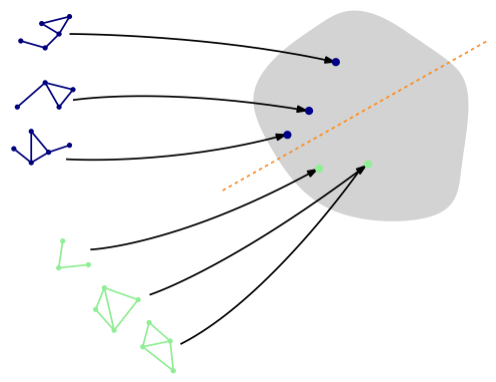

We will use the MUTAG dataset, part of the the TUDataset, a collection of benchmark datasets for graph classification and regression. In particular, MUTAG is composed by 188 graphs representing chemical compounds, belonging to two classes depending on their mutaagenic effect. Within each graph, nodes are labeled by the atom type and edges represent atom bonds.

In [ ]:
import torch
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')


Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2


Extracting data/TUDataset/MUTAG/MUTAG.zip
Processing...
Done!


As you may have observed, now the dataset contains several (smller) graphs, each associated with a label. We no longer have the training_mask. All nodes can be used to predict the property of the class, the split between training and test will be done on a graph level.

In [ ]:
torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:150]
test_dataset = dataset[150:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


In [ ]:
data = train_dataset[149]  # Get the first graph object.

display(print(data))

Data(edge_index=[2, 44], x=[21, 7], edge_attr=[44, 4], y=[1])


None

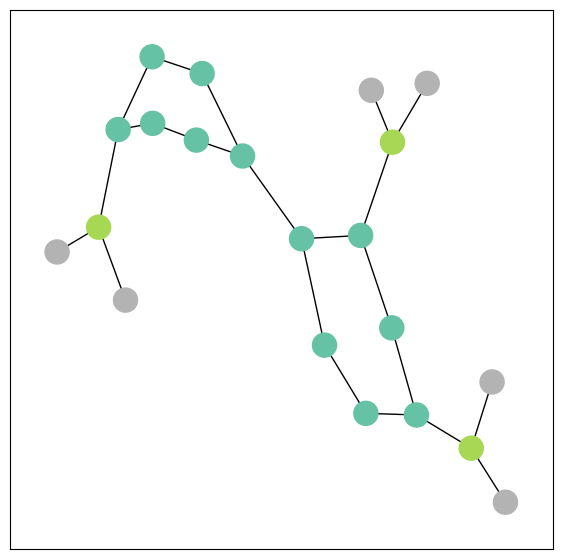

In [ ]:
G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.x.argmax(-1), node_size=300)

## Mini-batching of graphs

Since graphs in graph classification datasets are usually small, a good idea is to **batch the graphs** before inputting them into a Graph Neural Network to guarantee full GPU utilization.

Adjacency matrices are stacked in a diagonal fashion (creating a giant graph that holds multiple isolated subgraphs), and node and target features are simply concatenated in the node dimension:

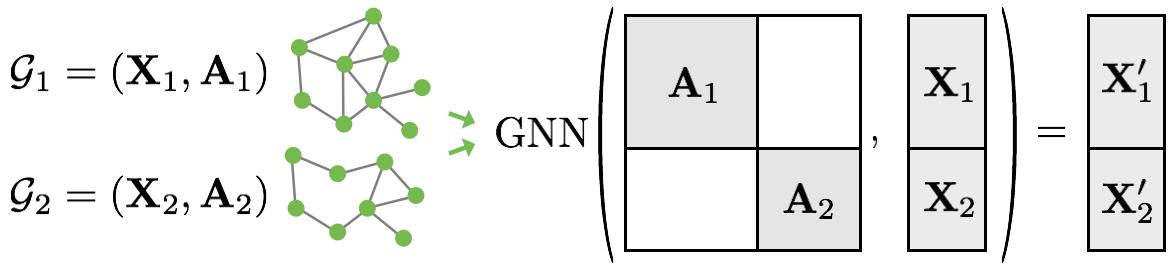

This procedure has some crucial advantages over other batching procedures:

1. GNN operators that rely on a message passing scheme do not need to be modified since messages are not exchanged between two nodes that belong to different graphs.

2. There is no computational or memory overhead since adjacency matrices are saved in a sparse fashion holding only non-zero entries, *i.e.*, the edges.

PyTorch Geometric automatically takes care of **batching multiple graphs into a single giant graph** with the help of the [`torch_geometric.data.DataLoader`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.DataLoader) class:

DataBatch(edge_index=[2, 2626], x=[1180, 7], edge_attr=[2626, 4], y=[64], batch=[1180], ptr=[65])

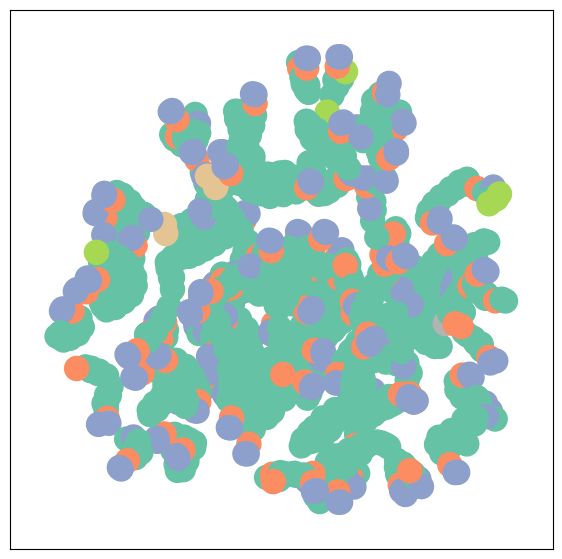

In [ ]:
from torch_geometric.loader import DataLoader

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

batch = next(iter(train_loader))

display(batch)
G = to_networkx(batch, to_undirected=True)
visualize_graph(G, color=batch.x.argmax(-1), node_size=300)

Here, we opt for a `batch_size` of 64, leading to 3 (randomly shuffled) mini-batches, containing all $2 \cdot 64+22 = 150$ graphs.

Furthermore, each `Batch` object is equipped with a **`batch` vector**, which maps each node to its respective graph in the batch:

$$
\textrm{batch} = [ 0, \ldots, 0, 1, \ldots, 1, 2, \ldots ]
$$

## Training a Graph Neural Network (GNN)

Training a GNN for graph classification usually follows a simple recipe:

1. Embed each node by performing multiple rounds of message passing
2. Aggregate node embeddings into a unified graph embedding (**readout layer**)
3. Train a final classifier on the graph embedding

There exists multiple **readout layers** in literature, but the most common one is to simply take the average of node embeddings:

$$
\mathbf{x}_{\mathcal{G}} = \frac{1}{|\mathcal{V}|} \sum_{v \in \mathcal{V}} \mathcal{x}^{(L)}_v
$$

PyTorch Geometric provides this functionality via [`torch_geometric.nn.global_mean_pool`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.glob.global_mean_pool), which takes in the node embeddings of all nodes in the mini-batch and the assignment vector `batch` to compute a graph embedding of size `[batch_size, hidden_channels]` for each graph in the batch.

The final architecture for applying GNNs to the task of graph classification then looks as follows and allows for complete end-to-end training:

In [ ]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.0, training=self.training)
        x = self.lin(x)

        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


Here, we again make use of the [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv) with $\mathrm{ReLU}(x) = \max(x, 0)$ activation for obtaining localized node embeddings, before we apply our final classifier on top of a graph readout layer.

Let's train our network for a few epochs to see how well it performs on the training as well as test set:

In [ ]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    total_loss = 0
    correct=0
    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.
         total_loss += loss.item()

         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.

    return total_loss, correct/ len(train_loader.dataset)

def test():
     model.eval()

     correct = 0
     for data in test_loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(test_loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 171):
    loss, train_acc = train()
    test_acc = test()
    print(f'Epoch: {epoch:03d},   Loss: {loss:.4f} Train Acc: {train_acc:.4f} Test Acc: {test_acc:.4f}')
    # print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001,   Loss: 2.0566 Train Acc: 0.5867 Test Acc: 0.7368
Epoch: 002,   Loss: 2.0321 Train Acc: 0.6467 Test Acc: 0.7368
Epoch: 003,   Loss: 2.0090 Train Acc: 0.6467 Test Acc: 0.7368
Epoch: 004,   Loss: 1.9890 Train Acc: 0.6467 Test Acc: 0.7368
Epoch: 005,   Loss: 2.0123 Train Acc: 0.6467 Test Acc: 0.7368
Epoch: 006,   Loss: 1.8914 Train Acc: 0.6467 Test Acc: 0.7368
Epoch: 007,   Loss: 1.8731 Train Acc: 0.6467 Test Acc: 0.7368
Epoch: 008,   Loss: 1.8874 Train Acc: 0.6467 Test Acc: 0.7368
Epoch: 009,   Loss: 1.8847 Train Acc: 0.6467 Test Acc: 0.7368
Epoch: 010,   Loss: 1.8983 Train Acc: 0.6467 Test Acc: 0.7368
Epoch: 011,   Loss: 1.8571 Train Acc: 0.6467 Test Acc: 0.7368
Epoch: 012,   Loss: 1.9354 Train Acc: 0.6467 Test Acc: 0.7368
Epoch: 013,   Loss: 1.7813 Train Acc: 0.6467 Test Acc: 0.7368
Epoch: 014,   Loss: 1.8417 Train Acc: 0.6467 Test Acc: 0.7368
Epoch: 015,   Loss: 1.9270 Train Acc: 0.6467 Test Acc: 0.7368
Epoch: 016,   Loss: 1.8840 Train Acc: 0.6467 Test Acc: 0.7368
Epoch: 0

## Now is your turn!

Play around with GNNs for both node and graph classification:
- try to increase or decrease the number of layers, their size, change the activation function add add dropouts... Good targets are test accuracies of:
  - \> 80% for Cora
  - \> 85% for MUTAG

- visualize the node embeddings (for Cora) and graph embeddings (for MUTAG) during training or in different layers. What happens? Why? You can use tSNE to visualize the multidimensional vectors into a bidimensional scatter plot.


In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")

#### Exploring the explainability of the Graph Attention Mechanism
Let's now use the graph attention mechanism in our convolutional layers (implemented by the [GATConv](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GATConv.html#torch_geometric.nn.conv.GATConv) class).
- Are there any edge more "relevant" than the others?
- How does the attention changes in the different layers?

Hint: The GATConv forward method accepts an extra argument *return_attention_weights*. If set to true, you will receive as output of the method both the new node features and the per edge attention weights.